## 1. Introduction

'''
=================================================
Milestone 2 Phase 1

Nama  : Felix Giancarlo
Batch : CODA-RMT-001

This progam is made for phase 1 milestone for Hacktiv8 Comprehensive Data Analytics Program.

This progam mission is to do a visual analyzing and statistical analyzing on a superstore sales report.

This progam will Extract, Transform, Load, and Clean the data from csv using Pandas.

It will later be analyzed with matpolib, scipy, numpy and etc.
'''

## 2. Problem Identification

### Business Understanding
The Superstore dataset offers a comprehensive view of sales, profits, and product performance, providing valuable insights for business strategy. As a graduate of Hacktiv8’s Data Analytics program The store have assigned me a task, The task is to leverage this dataset to optimize sales and profitability across all product categories while minimizing cancellations and returns. The primary focus is on driving a 20% increase in overall profit and achieving a 20% reduction in product cancellations and returns by the end of next year. This dual strategy will enhance customer satisfaction and operational efficiency, ultimately boosting revenue.

Through detailed analysis, I will identify factors contributing to cancellations and returns, when and where is the product makes the most and the least profits. These insights will inform targeted interventions to enhance sales performance and improve the overall customer experience.

### SMART
1. Specific: Increase total sales and reduce cancellations and returns by 20%.
2. Measurable: Achieve a 20% growth in sales revenue and reduce the percentage of cancellations and returns by 20%.
3. Achievable: Analyze Superstore data to identify product trends, optimize pricing, reduce shipping time, and develop strategies to reduce cancellations and returns.
4. Relevant: Improving sales and reducing operational inefficiencies directly align with increasing overall business profitability.
5. Time-bound: Achieve these goals by the end of next year.

### SMART Summary
By leveraging the Superstore dataset, I aim to drive a 20% increase in annual sales revenue and achieve a 20% reduction in product cancellations and returns by the end of next year. These goals will be achieved through data-driven insights, focusing on product optimization, pricing strategies, reducing shipping time, and addressing the causes of cancellations and returns. This initiative aligns with the broader objective of enhancing operational efficiency and maximizing profitability for the Superstore business.

### Key Questions
1. Do shipping time (order date untill shipping date), payment mode, category contributes to product returns?
2. What product categories generate the highest profits?
3. What are the total orders for each category?
4. Where are the regions with the lowest and highest profitability?
5. When are returns most likely to happen?
6. When are the months profits is at peak and lowest?

In [73]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, mannwhitneyu

## 3. Data Loading

In [74]:
df = pd.read_csv('SuperStore_Sales_Dataset.csv')

## 4. Data Cleaning

In [75]:
# Drop useless columns
df = df.drop(['Row ID+O6G3A1:R6', 'ind1', 'ind2'], axis=1)

# Drop columns with more than 50% NaN values, but keep 'Returns' even if it has NaN
threshold = len(df) * 0.5
columns_to_drop = [col for col in df.columns if col != 'Returns' and df[col].isna().sum() > threshold]
df = df.drop(columns=columns_to_drop, axis=1)

# Drop rows with NA values in other columns except 'Returns'
df = df.dropna(subset=[col for col in df.columns if col != 'Returns'])

# Drop duplicated rows
df = df.drop_duplicates()

# Convert dates to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d-%m-%Y')

print(df.info())
print(df.describe())
df.to_csv("cleaned_SuperStore_Sales_Dataset.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5901 entries, 0 to 5900
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       5901 non-null   object        
 1   Order Date     5901 non-null   datetime64[ns]
 2   Ship Date      5901 non-null   datetime64[ns]
 3   Ship Mode      5901 non-null   object        
 4   Customer ID    5901 non-null   object        
 5   Customer Name  5901 non-null   object        
 6   Segment        5901 non-null   object        
 7   Country        5901 non-null   object        
 8   City           5901 non-null   object        
 9   State          5901 non-null   object        
 10  Region         5901 non-null   object        
 11  Product ID     5901 non-null   object        
 12  Category       5901 non-null   object        
 13  Sub-Category   5901 non-null   object        
 14  Product Name   5901 non-null   object        
 15  Sales          5901 n

## 5. Analysis and Statistics

## Check Data Distribution

In [76]:
# Calculate skewness and kurtosis for the 'Profit' column using pandas
profit_skewness = df['Profit'].skew()
profit_kurtosis = df['Profit'].kurt()
sales_skewness = df['Sales'].skew()
sales_kurtosis = df['Sales'].kurt()

# Display skewness and kurtosis
print(f"Skewness of Profit: {profit_skewness:.2f}")
print(f"Kurtosis of Profit: {profit_kurtosis:.2f}")
print(f"Skewness of Sales: {sales_skewness:.2f}")
print(f"Kurtosis of Sales: {sales_kurtosis:.2f}")

Skewness of Profit: 8.43
Kurtosis of Profit: 410.14
Skewness of Sales: 5.95
Kurtosis of Sales: 54.74


- Result shows that, profit and sales is not normally distributed, they contain many outliers.

## Key Question

## 1. Do shipping time (order date untill ship date), payment mode, contributes to product returns?

- Shipping time

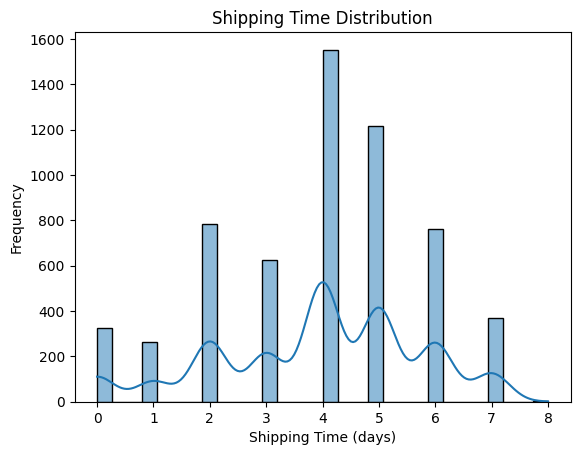

Skewness of Shipping Time: -0.39303684654774135
Kurtosis of Shipping Time: -0.4122454726847402


In [77]:
# Calculate shipping time (in days)
df['Shipping Time'] = (df['Ship Date'] - df['Order Date']).dt.days

sns.histplot(df['Shipping Time'], kde=True, bins=30)
plt.title('Shipping Time Distribution')
plt.xlabel('Shipping Time (days)')
plt.ylabel('Frequency')
plt.show()

# Calculate skewness and kurtosis
skewness_value = df['Shipping Time'].skew()
kurtosis_value = df['Shipping Time'].kurtosis()

# Display skewness and kurtosis
print(f"Skewness of Shipping Time: {skewness_value}")
print(f"Kurtosis of Shipping Time: {kurtosis_value}")

- Skewness of -0.39 suggests that the data is slightly negatively skewed
- kurtosis of -0.4 suggests that the data is not normally distributed, but this is not very extreme.

Therefore the Mann-Whitney U Test is still appropriate to use for comparing the Shipping Time between returned and non-returned products.

<Figure size 1000x600 with 0 Axes>

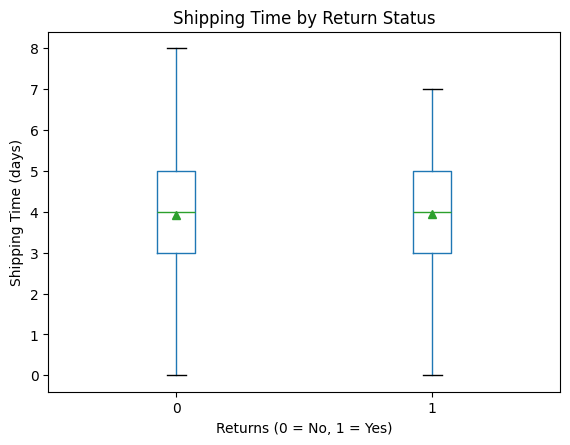

Mann-Whitney U Test:
Statistic: 801424.5, P-value: 0.8798525754411439
There is no significant difference in shipping time between returned and non-returned products.


In [78]:
# Clean and categorize the Returns column
df['Returns'] = df['Returns'].notna().astype(int)  # 1 if returned, 0 otherwise

# Plot distribution of shipping time for returned and non-returned products
plt.figure(figsize=(10, 6))
df.boxplot(column='Shipping Time', by='Returns', grid=False, showmeans=True)
plt.title('Shipping Time by Return Status')
plt.suptitle('')  # Remove default title
plt.xlabel('Returns (0 = No, 1 = Yes)')
plt.ylabel('Shipping Time (days)')
plt.show()

# Perform statistical test using Mann-Whitney U Test
returned = df[df['Returns'] == 1]['Shipping Time']
not_returned = df[df['Returns'] == 0]['Shipping Time']
stat, p_value = stats.mannwhitneyu(returned, not_returned, alternative='two-sided')

print(f"Mann-Whitney U Test:\nStatistic: {stat}, P-value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("There is a significant difference in shipping time between returned and non-returned products.")
else:
    print("There is no significant difference in shipping time between returned and non-returned products.")

- Payment Mode

Contingency Table:
Returns          1
Payment Mode      
COD           2453
Cards         1284
Online        2164

Chi-Square Test:
Chi2 Statistic: 0.0, P-value: 1.0
There is no significant association between payment mode and returns.


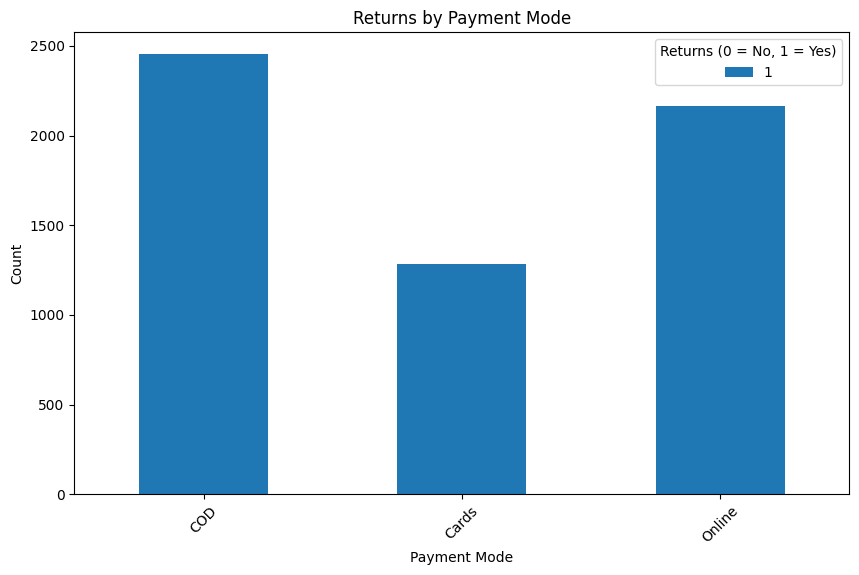

In [79]:
# Clean and categorize the Returns column
df['Returns'] = df['Returns'].notna().astype(int)  # 1 if returned, 0 otherwise

# Create a contingency table for Payment Mode and Returns
contingency_table = pd.crosstab(df['Payment Mode'], df['Returns'])
print("Contingency Table:")
print(contingency_table)

# Perform Chi-Square Test of Independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Test:\nChi2 Statistic: {chi2}, P-value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("There is a significant association between payment mode and returns.")
else:
    print("There is no significant association between payment mode and returns.")

# Visualize the relationship
contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Returns by Payment Mode')
plt.xlabel('Payment Mode')
plt.ylabel('Count')
plt.legend(title='Returns (0 = No, 1 = Yes)')
plt.xticks(rotation=45)
plt.show()

## 2. What product categories generate the highest profits?

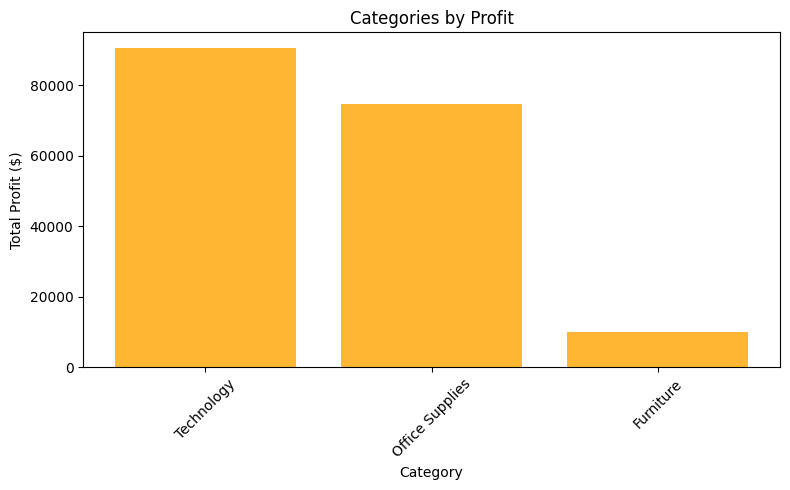

In [80]:
# Group data by Category and calculate total profit
category_summary = df.groupby('Category').agg({'Profit': 'sum'}).reset_index()

# Sort by highest profits
category_summary = category_summary.sort_values(by='Profit', ascending=False)


# Plot all categories by profit
plt.figure(figsize=(8, 5))
plt.bar(category_summary['Category'], category_summary['Profit'], color='orange', alpha=0.8)
plt.title('Categories by Profit')
plt.xlabel('Category')
plt.ylabel('Total Profit ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that, based on the data, technolgy makes the most profit, while office supplies makes the second most and furniture makes the least amount of profit.

## 3. What are the total orders for each category?

Total Orders for Each Category:
          Category  Total Line Items
1  Office Supplies              3569
0        Furniture              1249
2       Technology              1083


KeyError: 'Total Line Itemszz'

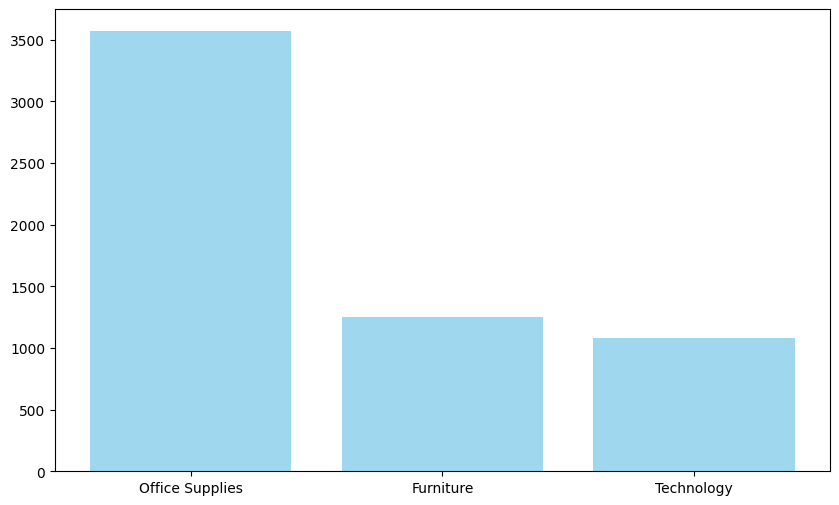

In [ ]:
# Group data by Category and count the total orders
category_orders = df.groupby('Category').size().reset_index(name='Total Line Items')

# Sort by the number of line items in descending order
category_orders = category_orders.sort_values(by='Total Line Items', ascending=False)

# Display the total orders for each category
print("Total Orders for Each Category:")
print(category_orders)

# Plot total orders for each category
plt.figure(figsize=(10, 6))
plt.bar(category_orders['Category'], category_orders['Total Line Items'], color='skyblue', alpha=0.8)

# Add labels to the bars
for index, value in enumerate(category_orders['Total Line Items']):
    plt.text(index, value + 0.5, f"{value}", ha='center', va='bottom', fontsize=10)

plt.title('Total Orders for Each Category')
plt.xlabel('Category')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Based on the plot, we can conclude that Office Supplies product is the most favorable and is the most ordered, while furniture and technology is the least favored. Maybe because of the product price, because usually technology and furniture product price is way higher than office supplies product.

## 4. Where are the regions with the lowest and highest profitability?

Region with Highest Profitability:
  Region      Profit
3   West  67859.9582

Region with Lowest Profitability:
  Region      Profit
2  South  26551.7163


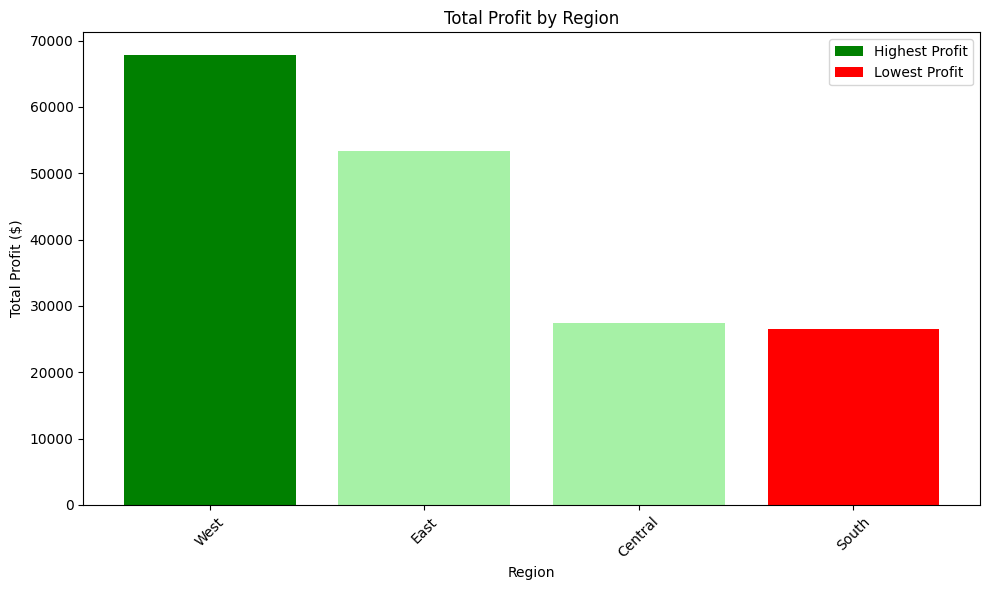

In [ ]:
# Group data by Region and calculate total profit
region_profit = df.groupby('Region').agg({'Profit': 'sum'}).reset_index()

# Sort the data by Profit in descending order
region_profit_sorted = region_profit.sort_values(by='Profit', ascending=False)

# Get the region with the highest profit
highest_profit_region = region_profit_sorted.head(1)

# Get the region with the lowest profit
lowest_profit_region = region_profit_sorted.tail(1)

# Display the results
print("Region with Highest Profitability:")
print(highest_profit_region)

print("\nRegion with Lowest Profitability:")
print(lowest_profit_region)

# Plot total profit by region
plt.figure(figsize=(10, 6))
plt.bar(region_profit_sorted['Region'], region_profit_sorted['Profit'], color='lightgreen', alpha=0.8)

# Highlight the highest and lowest profit regions
plt.bar(highest_profit_region['Region'], highest_profit_region['Profit'], color='green', alpha=1.0, label='Highest Profit')
plt.bar(lowest_profit_region['Region'], lowest_profit_region['Profit'], color='red', alpha=1.0, label='Lowest Profit')

# Add labels and title
plt.title('Total Profit by Region')
plt.xlabel('Region')
plt.ylabel('Total Profit ($)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Based on the data, we can see that West region have the most profits while South have the lowest profit margin and Central also comes second in lowest profit.

# 5. When are the months profits is at peak and lowest?

Month with Peak Profit:
Order Month       December
Total Profit    26368.0513
Name: 2, dtype: object

Month with Lowest Profit:
Order Month         April
Total Profit    3911.1049
Name: 0, dtype: object


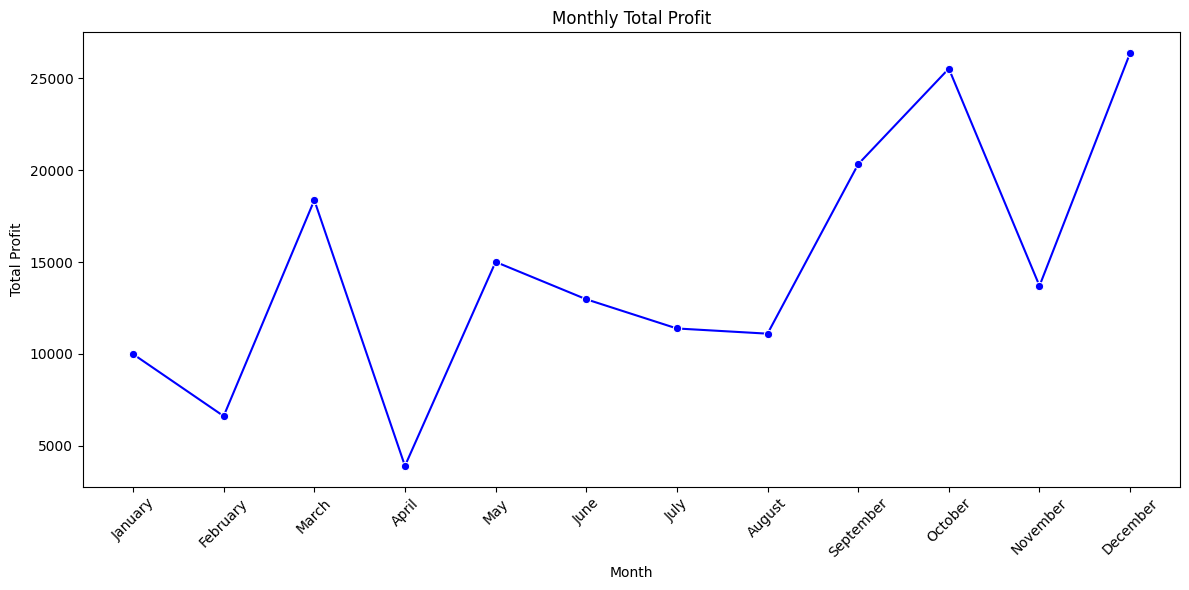

In [ ]:
# Extract month names from 'Order Date'
df['Order Month'] = df['Order Date'].dt.month_name()

# Group by 'Order Month' and calculate the total profit for each month
monthly_profit = (
    df.groupby('Order Month')['Profit']
    .sum()
    .reset_index(name='Total Profit')
)

# Reorder months for proper chronological order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_profit['Order Month'] = pd.Categorical(monthly_profit['Order Month'], categories=month_order, ordered=True)
monthly_profit = monthly_profit.sort_values('Order Month')

# Find the months with peak and lowest profits
peak_profit_month = monthly_profit.loc[monthly_profit['Total Profit'].idxmax()]
lowest_profit_month = monthly_profit.loc[monthly_profit['Total Profit'].idxmin()]

# Display the results
print("Month with Peak Profit:")
print(peak_profit_month)

print("\nMonth with Lowest Profit:")
print(lowest_profit_month)

# Optional: Plot the total profit by month
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_profit, x='Order Month', y='Total Profit', marker='o', color='b')
plt.title('Monthly Total Profit')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the bar chart, the peak in profit is in December while the lowest point is in April.

# 6. When are the months returns most likely to happen?

Unique Order Months: ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
Monthly Returns Data:
   Order Month  Return Count
4      January           245
3     February           190
7        March           401
0        April           373
8          May           467
6         June           444
5         July           427
1       August           394
11   September           822
10     October           494
9     November           829
2     December           815


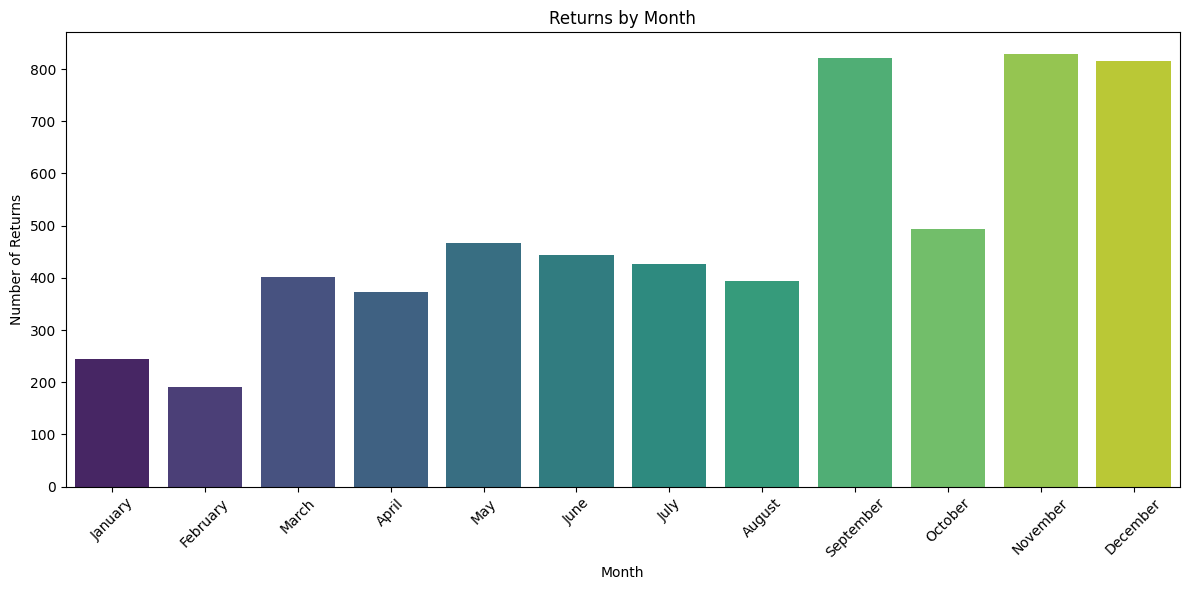

In [ ]:
# Clean and categorize the Returns column
df['Returns'] = df['Returns'].notna().astype(int)  # 1 if returned, 0 otherwise

# Extract month names from 'Order Date'
df['Order Month'] = df['Order Date'].dt.month_name()

# Debug: Check the extracted months
print("Unique Order Months:", df['Order Month'].unique())

# Analyze returns by month
monthly_returns = (
    df[df['Returns'] == 1]  # Filter for returned products
    .groupby('Order Month')
    .size()
    .reset_index(name='Return Count')
)

# Reorder months for proper chronological order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_returns['Order Month'] = pd.Categorical(monthly_returns['Order Month'], categories=month_order, ordered=True)
monthly_returns = monthly_returns.sort_values('Order Month')

# Debug: Check grouped data
print("Monthly Returns Data:")
print(monthly_returns)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_returns, x='Order Month', y='Return Count', palette='viridis',hue='Order Month',)
plt.title('Returns by Month')
plt.xlabel('Month')
plt.ylabel('Number of Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the chart, we can conclude that , peak returns happens at September, November and December while lowest returns happens at Febuary and January coming in close. This is normal because peak orders also happen at that time, so of course there will be many returns during that month also.

## 6. Summary and Conclusion

### Summary Insight

1. Factors Contributing to Returns:
- Shipping time and payment mode do not show a significant impact on product returns.

2. Product Categories with Highest Sales and Profits:
- Technology generates the highest profits.
- Office Supplies comes second, followed by Furniture, which has the least profit.

3. Orders by Product Category:
- Office Supplies is the most ordered category.
- Furniture and Technology are less favored, likely due to their higher prices compared to Office Supplies.

4. Regional Profitability:
- West Region has the highest profitability.
- South Region records the lowest profit margin, followed closely by the Central Region.

5. Timing of Returns:
- Returns peak in September, November, and December, correlating with high order volumes during these months.
- Returns are least common in January and February.

6. Peak and Lowest Profit Months:
- Profits peak in October and December.
- Profits are at their lowest in April.

### Conclusion

Based from the data we gathered, in order to improve our profits by 20% and reduce product return by 20% on next year we can:
- On furniture products, becuase furniture product is the least favorable and have the lowest order. Consider lowering the price or give promos and discount on furniture products, this way, it'll attract more customer on buying furniture products.
- In the West, where the profit margins are already high, consider a price increase if the market can bear it. This will help to offset lower profits in other regions without reducing overall sales volume. While, for the South and Central regions, consider a price decrease to attract more consumer.
- In September - December consider increasing supply chains, because they are the months with the peak orders while consider limiting/decreasing supply chains when in April, because it is the month with the lowest orders.
- Also negotiate better terms with suppliers for bulk purchases of popular items in preparation for peak months (September - December).
- Introduce Mid-Spring Discounts during April to attract customers and boost sales during this slow period.
- Provide perks for completed purchases, such as discounts or loyalty points, encouraging customers to follow through with their orders and not cancelling them.


By Applying these recomendations, we can achieve a 20% more on profits and reduce 20% on product returns.